# Projet 7 - Elaborer un modele de scoring

## Modelisation - MLFlow

In [1]:
#%pip install hyperopt
#%pip install xgboost
#%pip install lightgbm
#%pip install lime
#%pip install shap
#%pip install -U evidently

In [32]:
import os
import pickle
import dill

from collections import Counter

import numpy as np
import pandas as pd

from sklearn.model_selection import cross_val_predict, cross_validate, cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler 

from hyperopt import tpe, hp, fmin, space_eval, STATUS_OK, Trials, SparkTrials 
from hyperopt.pyll.base import scope

import xgboost as xgb

import lightgbm as ltb

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from lime import lime_tabular
import shap

from evidently import Report
from evidently.presets import DataDriftPreset

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_theme(palette="Set1")

### Chargement des dataset

In [3]:
data = pd.read_csv("../Sources/train_feature_engineering.csv", index_col=[0])
data_test = pd.read_csv("../Sources/test_feature_engineering.csv", index_col=[0])

### Initialisation de plusieurs fonctions

In [4]:
# Function to display confusion matrix
def display_confusion_matrix(y_test, y_pred, model_name="Model"):
    
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(model_name + ": Confusion matrix")
    plt.grid(visible=None)
    plt.show()

In [5]:
# Function to compute roc curve
def compute_roc_curve(y_test, y_pred_proba, model_name="Model", disp_best_th=False):
    # Compute metrics
    fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # Create fig
    plt.figure()
    plt.title(model_name + ": ROC curve")

    # Display x=y
    sns.lineplot(x=[0, 1], y=[0, 1], linestyle='--')

    # Display ROC curve
    sns.lineplot(x=fpr, y=tpr, legend='brief', label="AUC = {:.3f}".format((auc)))

    if disp_best_th is True:
        # Compute best threshold
        o_tpr = tpr[np.argmin(np.abs(fpr+tpr-1))]
        o_fpr = fpr[np.argmin(np.abs(fpr+tpr-1))]
        o_threshold = thresholds[np.argmin(np.abs(fpr+tpr-1))]

        # Display best threshold
        sns.scatterplot(x=[o_fpr], y=[o_tpr], legend='brief', label="Best threshold = {:.3f}".format(o_threshold))

    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()

    # Return AUC score
    return auc

In [6]:
# Return the best model from hyperopt trials
def trials_best_model(trials):
    
    valid_trial_list = [trial for trial in trials if STATUS_OK == trial['result']['status']]
    losses = [float(trial['result']['loss']) for trial in valid_trial_list]
    min_loss_idx = np.argmin(losses)
    best_trial_obj = valid_trial_list[min_loss_idx]
    print("Best result :", best_trial_obj['result']['loss'])
    return best_trial_obj['result']['model']

### Initialisation MLFlow

In [7]:
#%pip install mlflow

In [8]:
from mlflow import log_metric, log_param, log_artifacts

In [9]:
import sys, mlflow
print("PYTHON =", sys.executable)
print("MLFLOW =", mlflow.__version__)

PYTHON = c:\Users\cosic\anaconda3\python.exe
MLFLOW = 3.3.2


In [10]:
#& "c:\Users\cosic\anaconda3\python.exe" -m mlflow server --host 127.0.0.1 --port 5000

In [11]:
URI = "http://localhost:5000/"
EXPERIMENT_NAME = "first_mlflow_experiment"
try:
    mlflow.set_tracking_uri(URI)
    EXPERIMENT_ID = mlflow.set_experiment(EXPERIMENT_NAME)
except (ImportError, ModuleNotFoundError):
    print("Unfortunately, MLflow isn't available. :(")

KeyboardInterrupt: 

In [ ]:
# Function to log model to mlflow
def log_mlflow(model, 
                name: str, 
                custom_score: float, 
                n_estimator: int | None = None, 
                max_depth: int | None = None, 
                auc_score: float | None = None, 
                f1_score: float | None = None, 
                acc_score: float | None = None,
               train_class_0: int | float | None = None, 
               train_class_1: int | float | None = None,
               registered_model_name: str | None = None):

    # Track params and metrics 
    with mlflow.start_run(run_name=name) as run:

        # Set parameters
        params = {
            "n_estimators": n_estimator,
            "max_depth": max_depth,
            "train_class_0": train_class_0,
            "train_class_1": train_class_1
        }
        mlflow.log_params({k: v for k, v in params.items() if v is not None})

        # Set metrics only if not None
        metrics = {
            "Custom score": custom_score,
            "AUC": auc_score,
            "F1": f1_score,
            "Accuracy": acc_score
        }
        mlflow.log_metrics({k: v for k, v in metrics.items() if v is not None})

        # Save model to artifacts
        mlflow.sklearn.log_model(
            sk_model=model,
            name=name,
            #signature=signature,
            registered_model_name=registered_model_name,  # ou None
        )

        return run.info.run_id # pratique pour tracer la run



## Data preparation

In [13]:
# Define target and features
TARGET = 'TARGET'
target = data[TARGET].to_numpy()
features = data.drop(columns=TARGET).to_numpy()
features_names = data.drop(columns=TARGET).columns.to_list()

# Define training set size
TRAIN_SIZE = 0.8

# Define random state
RANDOM_STATE = 42

### Valeurs manquantes

In [14]:
# Check missing values
nan_values = data.isna().sum().sum()
print("Missing values = {} ({:.2%})".format(nan_values, nan_values/data.size))

Missing values = 37539669 (20.14%)


#### Les valeurs manquantes peuvent etre traites directement par les modeles.
#### Dans un premier temps je vais gerer les valeurs manquantes et on fera une seconde methode plus tard.

In [15]:
# Create imputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

# Fit to data
imp_mean.fit(features)

# Transform data
features_fill = imp_mean.transform(features)

### Split data

#### Decoupage en training et testing

In [16]:
# Split dataset (filled)
x_train, x_test, y_train, y_test = train_test_split(features_fill, target, train_size=TRAIN_SIZE, random_state=RANDOM_STATE)

In [17]:
# Define stratifiedKfold
strat_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

## Balance data

In [18]:
y_train_counter = Counter(y_train)
print("Training target statistics:", y_train_counter)
print("Testing target statistics:", Counter(y_test))

# Print ratio
print("Ratio is 1:{:.0f}".format(y_train_counter[0] / y_train_counter[1]))

Training target statistics: Counter({0.0: 226132, 1.0: 19876})
Testing target statistics: Counter({0.0: 56554, 1.0: 4949})
Ratio is 1:11


#### Je vais définir un pipeline qui transforme d'abord l'ensemble de données d'entraînement avec SMOTE, puis ajuste le modèle

In [19]:
# Define oversampling and undersampling
over = SMOTE(sampling_strategy=0.5) # oversample to 1:2 ratio 
under = RandomUnderSampler(sampling_strategy=1) # undersample to 1:1 ratio

# Define pipeline
steps = [('over', over), ('under', under)]
pipeline = Pipeline(steps=steps)

# Transform the dataset
x_res, y_res = pipeline.fit_resample(x_train, y_train)

print("Training target statistics:", Counter(y_res))
print("Testing target statistics:", Counter(y_test))

Training target statistics: Counter({0.0: 113066, 1.0: 113066})
Testing target statistics: Counter({0.0: 56554, 1.0: 4949})


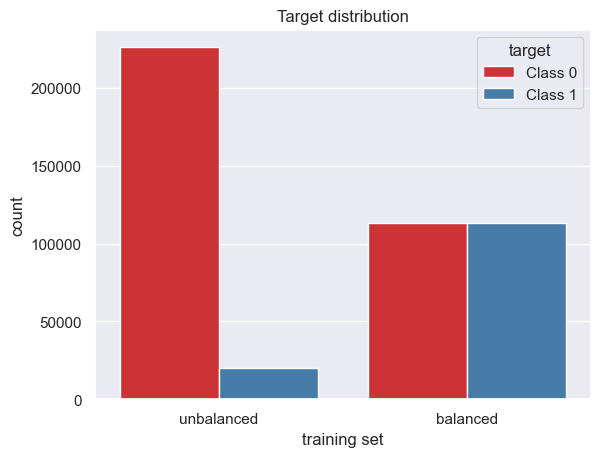

In [20]:
# Display barplot of distribution
class_distr_df = pd.DataFrame({'training set': ['unbalanced', 'unbalanced', 'balanced', 'balanced'],
                               'target': ['Class 0', 'Class 1', 'Class 0', 'Class 1'],
                               'count': [y_train_counter[0], y_train_counter[1], Counter(y_res)[0], Counter(y_res)[1]]})

# Display barplot
sns.barplot(class_distr_df, x='training set', y='count', hue='target')
plt.title("Target distribution")
plt.show()

## Elaboration du modele

* Le déséquilibre entre le nombre de bons et de moins bons clients doit être pris en compte pour élaborer un modèle pertinent, avec une méthode au choix
* Le déséquilibre du coût métier entre un faux négatif (FN - mauvais client prédit bon client : donc crédit accordé et perte en capital) et un faux positif (FP - bon client prédit mauvais : donc refus crédit et manque à gagner en marge)
* Vous pourrez supposer, par exemple, que le coût d’un FN est dix fois supérieur au coût d’un FP
* Vous créerez un score “métier” (minimisation du coût d’erreur de prédiction des FN et FP) pour comparer les modèles, afin de choisir le meilleur modèle et ses meilleurs hyperparamètres. Attention cette minimisation du coût métier doit passer par l’optimisation du seuil qui détermine, à partir d’une probabilité, la classe 0 ou 1 (un “predict” suppose un seuil à 0.5 qui n’est pas forcément l’optimum)
* En parallèle, maintenez pour comparaison et contrôle des mesures plus techniques, telles que l’AUC et l’accuracy 

In [21]:
# Custom loss function based on business rule
def business_loss_func(y_true, y_pred):
    
    tp, fp, fn, tn = confusion_matrix(y_true, y_pred).ravel()
    cost = (fp + (10 * fn)) / len(y_true)
    return float(cost)

In [22]:
# # Custom loss function for xgboost
def xgb_custom_loss_func(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fnr = fn / (fn + tp)  # false negative rate
    fpr = fp / (fp + tn)  # false positive rate
    cost = float((10 * fnr) + fpr)
    
    grad = np.repeat(2 * cost, len(y_pred))
    hess = np.repeat(2, len(y_pred))

    return grad, hess

In [23]:
# Custom loss function for lightgbm
def lgbm_custom_loss_func(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fnr = fn / (fn + tp)  # false negative rate
    fpr = fp / (fp + tn)  # false positive rate
    cost = float((10 * fnr) + fpr)
    
    grad = 2 * cost
    hess = 2

#     return grad, hess

#### Je crée un score personnalisé avec la règle métier

In [24]:
# Create business score
business_score = make_scorer(business_loss_func, greater_is_better=True)

## Fonction pour la classification

In [25]:
# Function to compute predictions and metrics
def compute_classification_results(model, model_name, x_test, y_test):

    # Predict probability of class 1 (repay failure)
    y_pred_proba = model.predict_proba(x_test)[:,1]

    # Predict values 
    y_pred = model.predict(x_test)

    # Display confusion matrix
    display_confusion_matrix(y_test, y_pred, model_name=model_name)

    # Draw roc curve
    auc_score = compute_roc_curve(y_test, y_pred_proba, model_name=model_name)

    # Compute scores
    clf_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
    display(clf_report)

    # Display business loss func
    business_score = business_loss_func(y_test, y_pred)
    print("Business score =", business_score)

    return business_score, auc_score, clf_report

## Baseline DummyClassifier

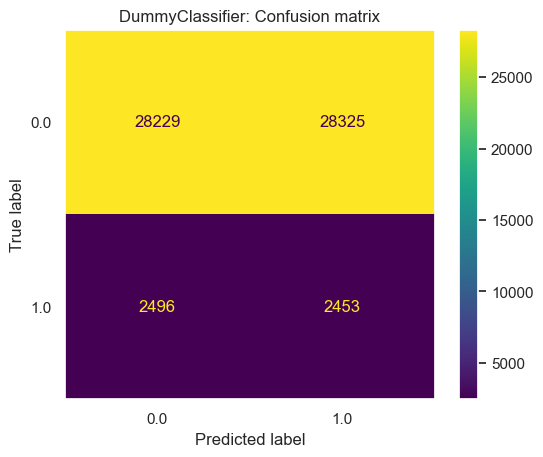

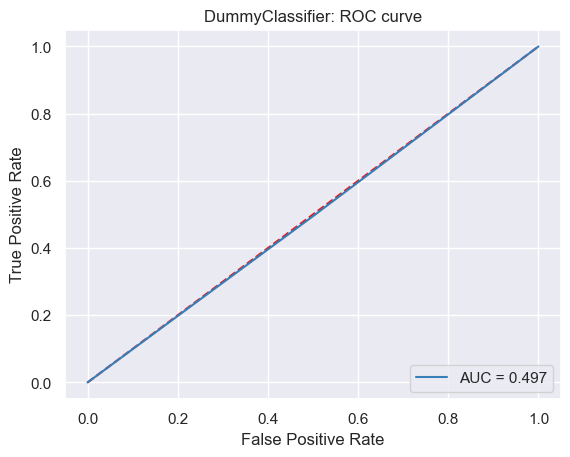

,precision,recall,f1-score,support
0.0,0.918763,0.499151,0.646868,56554.00000
1.0,0.079700,0.495656,0.137319,4949.00000
accuracy,0.498870,0.498870,0.498870,0.49887
macro avg,0.499232,0.497403,0.392094,61503.00000
weighted avg,0.851246,0.498870,0.605866,61503.00000


Business score = 0.8663805017641416


2025/09/04 13:47:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/04 13:47:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run DummyClassifier at: http://localhost:5000/#/experiments/0/runs/c4da77066f774697bffdaebc26989d6b
🧪 View experiment at: http://localhost:5000/#/experiments/0


'c4da77066f774697bffdaebc26989d6b'

In [ ]:
dc = DummyClassifier(strategy='stratified', random_state=RANDOM_STATE)
dc_name = 'DummyClassifier'

# Fit model
dc.fit(x_res, y_res)

# Compute results
dc_business_score, dc_auc, dc_report = compute_classification_results(dc, dc_name, x_test, y_test)

# Save logs
log_mlflow(dc, dc_name, 
           auc_score=dc_auc, 
           custom_score=dc_business_score,
           f1_score=dc_report.loc['weighted avg', 'f1-score'], 
           acc_score=dc_report.loc['accuracy', 'precision'],
           train_class_0=Counter(y_res)[0], 
           train_class_1=Counter(y_res)[1])

## Regression Logistique

c:\Users\cosic\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


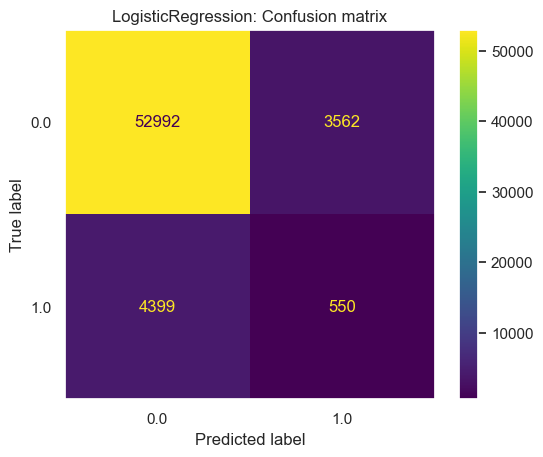

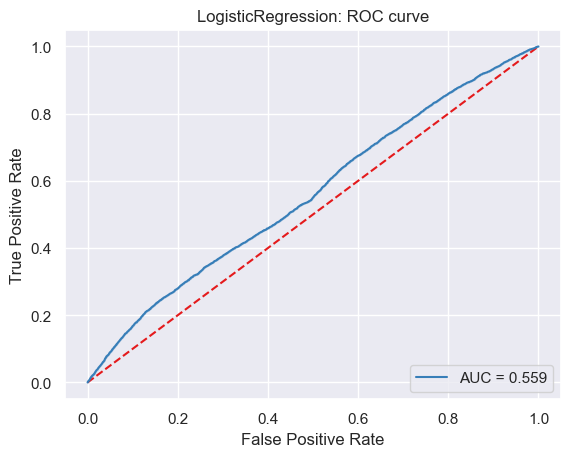

,precision,recall,f1-score,support
0.0,0.923350,0.937016,0.930133,56554.000000
1.0,0.133755,0.111134,0.121399,4949.000000
accuracy,0.870559,0.870559,0.870559,0.870559
macro avg,0.528553,0.524075,0.525766,61503.000000
weighted avg,0.859813,0.870559,0.865056,61503.000000


Business score = 0.773165536640489


2025/09/04 13:52:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/04 13:52:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogisticRegression at: http://localhost:5000/#/experiments/0/runs/f2eda3d021b54da8bacecb37252bb838
🧪 View experiment at: http://localhost:5000/#/experiments/0


'f2eda3d021b54da8bacecb37252bb838'

In [ ]:
# Create logistic regression model
lr = LogisticRegression(random_state=RANDOM_STATE)
lr_name = 'LogisticRegression'

# Train model
lr.fit(x_res, y_res)

# Compute results
lr_business_score, lr_auc, lr_report = compute_classification_results(lr, lr_name, x_test, y_test)

# Save logs
log_mlflow(lr, lr_name, 
           auc_score=lr_auc, 
           custom_score=lr_business_score,
           f1_score=lr_report.loc['weighted avg', 'f1-score'], 
           acc_score=lr_report.loc['accuracy', 'precision'],
           train_class_0=Counter(y_res)[0], 
           train_class_1=Counter(y_res)[1])

## LGBM

[LightGBM] [Info] Number of positive: 113066, number of negative: 113066
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.268439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135390
[LightGBM] [Info] Number of data points in the train set: 226132, number of used features: 569
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


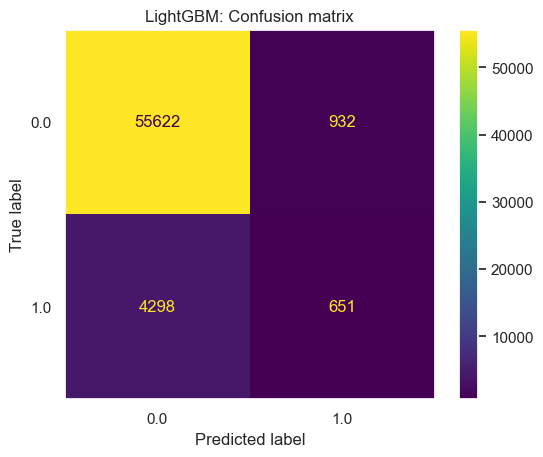

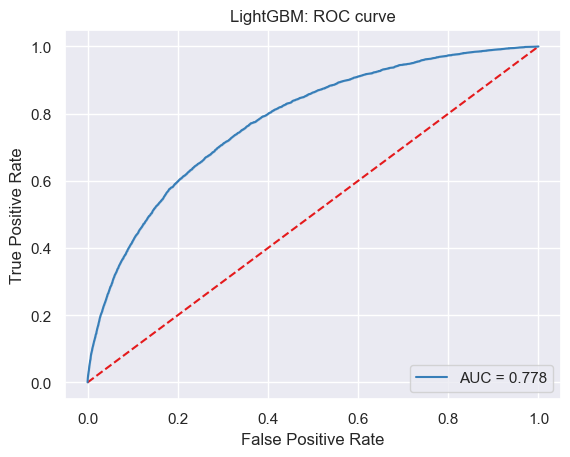

,precision,recall,f1-score,support
0.0,0.928271,0.983520,0.955097,56554.000000
1.0,0.411244,0.131542,0.199326,4949.000000
accuracy,0.914963,0.914963,0.914963,0.914963
macro avg,0.669758,0.557531,0.577212,61503.000000
weighted avg,0.886667,0.914963,0.894282,61503.000000


Business score = 0.7139814318000748


2025/09/04 14:05:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/04 14:05:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LightGBM at: http://localhost:5000/#/experiments/0/runs/0c944701882f44e1a5144548dba580a9
🧪 View experiment at: http://localhost:5000/#/experiments/0


'0c944701882f44e1a5144548dba580a9'

In [33]:
# Create light gradient boosting model classifier
lgbm = LGBMClassifier(random_state=RANDOM_STATE)
lgbm_name = 'LightGBM'

# Train model
lgbm.fit(x_res, y_res)

# Compute results
lgbm_business_score, lgbm_auc, lgbm_report = compute_classification_results(lgbm, lgbm_name, x_test, y_test)

# Save logs
lgbm_params = lgbm.get_params()
log_mlflow(lgbm, lgbm_name,
           custom_score=lgbm_business_score,
           auc_score=lgbm_auc,
           f1_score=lgbm_report.loc['weighted avg', 'f1-score'], 
           acc_score=lgbm_report.loc['accuracy', 'precision'],
           n_estimator=lgbm_params['n_estimators'],
           max_depth=lgbm_params['max_depth'], 
           train_class_0=Counter(y_res)[0],
           train_class_1=Counter(y_res)[1])

## XGBoost

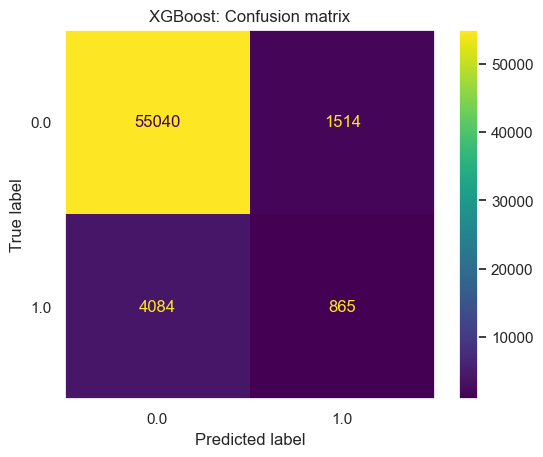

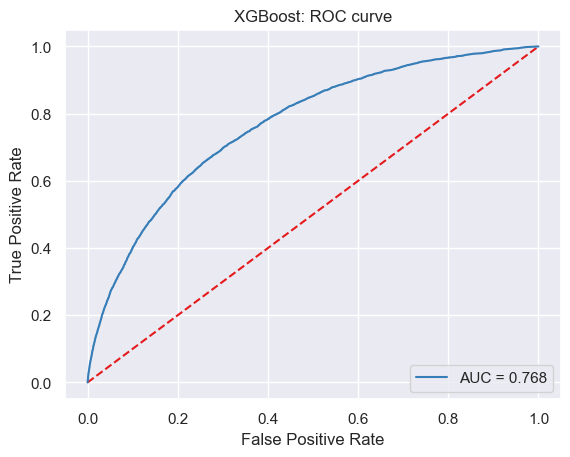

,precision,recall,f1-score,support
0.0,0.930925,0.973229,0.951607,56554.00000
1.0,0.363598,0.174783,0.236081,4949.00000
accuracy,0.908980,0.908980,0.908980,0.90898
macro avg,0.647261,0.574006,0.593844,61503.00000
weighted avg,0.885273,0.908980,0.894030,61503.00000


Business score = 0.6886493341788206


2025/09/04 14:07:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/04 14:07:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost at: http://localhost:5000/#/experiments/0/runs/4083b6b93868477db92a5eb48370fc7a
🧪 View experiment at: http://localhost:5000/#/experiments/0


'4083b6b93868477db92a5eb48370fc7a'

In [34]:
# Create XGBoost classifier
xgbc = xgb.XGBClassifier(random_state=RANDOM_STATE)
xgbc_name = 'XGBoost'

# Train model
xgbc.fit(x_res, y_res)

# Compute results
xgbc_business_score, xgbc_auc, xgbc_report = compute_classification_results(xgbc, xgbc_name, x_test, y_test)

# Save logs
xgbc_params = xgbc.get_params()
log_mlflow(xgbc, xgbc_name,
           custom_score=xgbc_business_score,
           auc_score=xgbc_auc,
           f1_score=xgbc_report.loc['weighted avg', 'f1-score'], 
           acc_score=xgbc_report.loc['accuracy', 'precision'],
           n_estimator=xgbc_params['n_estimators'],
           max_depth=xgbc_params['max_depth'], 
           train_class_0=Counter(y_res)[0],
           train_class_1=Counter(y_res)[1])

### Creer un tableau de comparaison

In [36]:
res_df = pd.DataFrame({
    'Model':['Dummy', 'LogisticRegression', 'LightGBM', 'XGBoost'],
    'Business score': [dc_business_score, lr_business_score, lgbm_business_score, xgbc_business_score],
    'Accuracy': [dc_report.loc['accuracy', 'precision'],
                 lr_report.loc['accuracy', 'precision'],
                 lgbm_report.loc['accuracy', 'precision'],
                 xgbc_report.loc['accuracy', 'precision']],
    'Precision': [dc_report.loc['macro avg', 'precision'],
                 lr_report.loc['macro avg', 'precision'],
                 lgbm_report.loc['macro avg', 'precision'],
                 xgbc_report.loc['macro avg', 'precision']],
    'Recall': [dc_report.loc['macro avg', 'recall'],
               lr_report.loc['macro avg', 'recall'],
               lgbm_report.loc['macro avg', 'recall'],
               xgbc_report.loc['macro avg', 'recall']],
    'F-1 score': [dc_report.loc['macro avg', 'f1-score'],
                  lr_report.loc['macro avg', 'f1-score'],
                  lgbm_report.loc['macro avg', 'f1-score'],
                  xgbc_report.loc['macro avg', 'f1-score']],
    'AUC score': [dc_auc, lr_auc, lgbm_auc, xgbc_auc]
})

display(res_df)

,Model,Business score,Accuracy,Precision,Recall,F-1 score,AUC score
0,Dummy,0.866381,0.498870,0.499232,0.497403,0.392094,0.497403
1,LogisticRegression,0.773166,0.870559,0.528553,0.524075,0.525766,0.558602
2,LightGBM,0.713981,0.914963,0.669758,0.557531,0.577212,0.777765
3,XGBoost,0.688649,0.908980,0.647261,0.574006,0.593844,0.767644


#### Notre priorite est la minimisation du cout metier (busniess score) donc XGBoost est le meilleur modele et le meilleur F1.
#### En parallele LGBM est tres proche, meilleur AUC (capacite de classement global), et une precision plus forte (mmoins de FP)
#### Je garde donc XGBoost

## Hyperparameters Tuning

{'colsample_bytree': 0.5, 'learning_rate': 0.30000000000000004, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.5735695333228519}
{'colsample_bytree': 1.0, 'learning_rate': 0.6000000000000001, 'max_depth': 11, 'min_child_weight': 2, 'n_estimators': 450, 'subsample': 0.6614946027947624}
{'colsample_bytree': 0.5, 'learning_rate': 0.30000000000000004, 'max_depth': 14, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8708336610370395}
{'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 13, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.5179816909968804}
{'colsample_bytree': 0.5, 'learning_rate': 0.7000000000000001, 'max_depth': 17, 'min_child_weight': 5, 'n_estimators': 450, 'subsample': 0.7152538454395364}
{'colsample_bytree': 0.5, 'learning_rate': 0.7000000000000001, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 50, 'subsample': 0.743755328809947}
{'colsample_bytree': 0.5, 'learning_rate': 0.2, 'max_depth': 9, 'min_child_

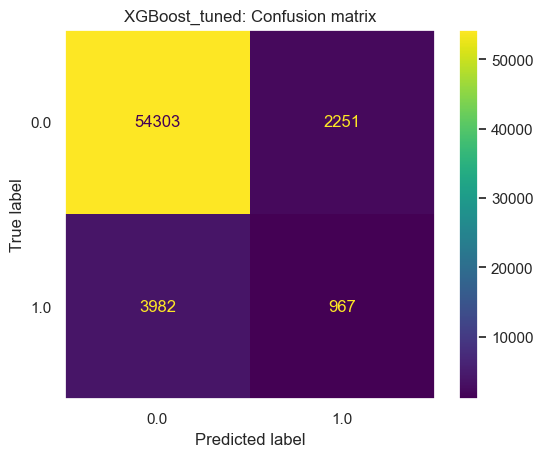

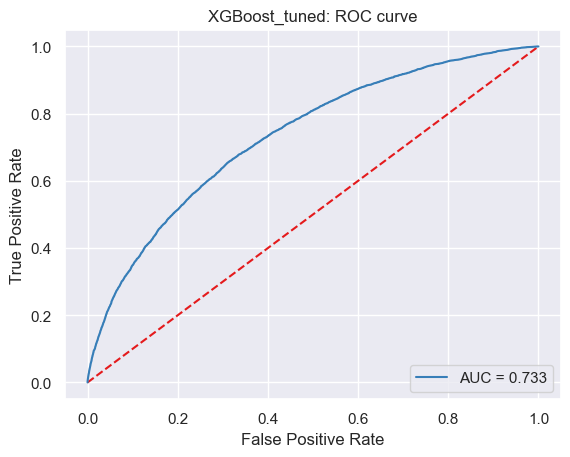

,precision,recall,f1-score,support
0.0,0.931681,0.960197,0.945724,56554.000000
1.0,0.300497,0.195393,0.236807,4949.000000
accuracy,0.898655,0.898655,0.898655,0.898655
macro avg,0.616089,0.577795,0.591265,61503.000000
weighted avg,0.880891,0.898655,0.888679,61503.000000


Business score = 0.6840479326211729


2025/09/04 15:16:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/04 15:16:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost_tuned at: http://localhost:5000/#/experiments/0/runs/b106d992ac81420f90e653fc84ed1999
🧪 View experiment at: http://localhost:5000/#/experiments/0


'b106d992ac81420f90e653fc84ed1999'

In [37]:
# Create XGBoost classifier for tuning
xgbt = xgb.XGBClassifier(random_state=RANDOM_STATE)
xgbt_name = 'XGBoost_tuned'

# Possible values of hyperparameters
xgbt_space = {'max_depth':  scope.int(hp.quniform("max_depth", 3, 18, 1)),
              'subsample':  hp.uniform('subsample', 0.5, 1.),
              'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.5),
              'learning_rate': hp.quniform('learning_rate', 0.1, 1, 0.1),
              'min_child_weight' : scope.int(hp.quniform('min_child_weight', 0, 10, 1)),
              'n_estimators': scope.int(hp.quniform('n_estimators', 50, 500, 50))}

# define objective function
def xgbt_tuning(params):
    print(params)
    xgbt.set_params(**params)
    score = cross_val_score(xgbt, x_res, y_res, scoring=business_score).mean()
    return {"loss": -score, "status": STATUS_OK, "model":xgbt}

# Initialize trials object
xgbt_trials = Trials()

# Find best model
xgbt_best = fmin(fn=xgbt_tuning, space=xgbt_space, algo=tpe.suggest, max_evals=10, trials=xgbt_trials)
xgbt_best_model = trials_best_model(xgbt_trials)
print(xgbt_best_model)

# Train model
xgbt_best_model.fit(x_res, y_res)

# Compute results
xgbt_business_score, xgbt_auc, xgbt_report = compute_classification_results(xgbt_best_model, xgbt_name, x_test, y_test)

# Save logs
xgbt_params = xgbt.get_params()
log_mlflow(xgbt_best_model, xgbt_name,
           custom_score=xgbt_business_score,
           auc_score=xgbt_auc,
           f1_score=xgbt_report.loc['weighted avg', 'f1-score'], 
           acc_score=xgbt_report.loc['accuracy', 'precision'],
           n_estimator=xgbt_params['n_estimators'],
           max_depth=xgbt_params['max_depth'], 
           train_class_0=Counter(y_res)[0],
           train_class_1=Counter(y_res)[1])

In [38]:
xgb_score_imp = (xgbc_business_score - xgbt_business_score) / xgbc_business_score
print("The XGBoost model improved the business score by {:.1%}".format(xgb_score_imp))

The XGBoost model improved the business score by 0.7%


#### Amelioration du modele XGBoost de 0.7 points.

## Custom Treshold

In [39]:
# Get proba predictions from xgbt model to be class 1 : repay failure
xgbt_proba = xgbt.predict_proba(x_test)[:,1]

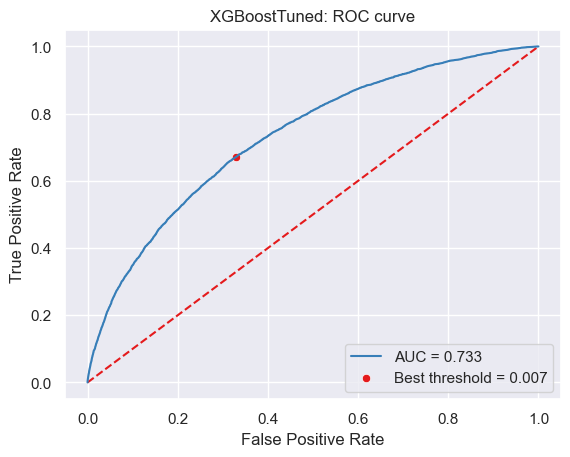

In [40]:
# Draw roc curve
auc_score = compute_roc_curve(y_test, xgbt_proba, model_name='XGBoostTuned', disp_best_th=True)

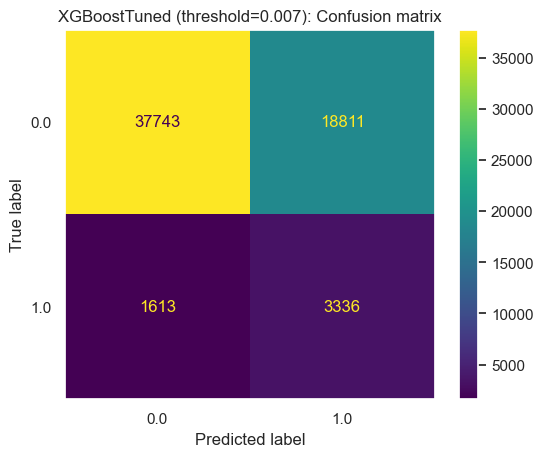

Business score = 0.5681186283595923


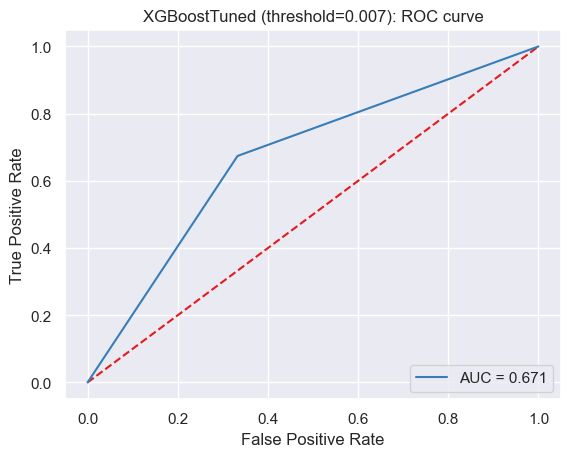

,precision,recall,f1-score,support
0.0,0.959015,0.667380,0.787050,56554.000000
1.0,0.150630,0.674076,0.246236,4949.000000
accuracy,0.667919,0.667919,0.667919,0.667919
macro avg,0.554823,0.670728,0.516643,61503.000000
weighted avg,0.893966,0.667919,0.743532,61503.000000


In [41]:
# Compute confusion matrix with custom threshold (0.007)
xgbt_pred_cstm = xgbt_proba >= 0.007
display_confusion_matrix(y_test, xgbt_pred_cstm, model_name='XGBoostTuned (threshold=0.007)')
business_score = business_loss_func(y_test, xgbt_pred_cstm)
print("Business score =", business_score)
auc_score = compute_roc_curve(y_test, xgbt_pred_cstm, model_name='XGBoostTuned (threshold=0.007)')
clf_report = pd.DataFrame(classification_report(y_test, xgbt_pred_cstm, output_dict=True)).transpose()
display(clf_report)